# EDA for the Emotion Image Dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Constants
DATASET_DIR = "/app/data/raw/fer2013/train"  # Updated for Docker container
EXPECTED_SIZE = (48, 48)

# Storage - for storing attributes
class_counts = {}
brightness_vals = []
contrast_vals = []  
class_brightness = {}  # brightness values per class
class_contrast = {}    # contrast values per class
small_images = []
invalid_modes = []
corrupted_files = []
sample_images = []

print("="*60)
print("EDA Configuration")
print("="*60)
print(f"Dataset Directory : {DATASET_DIR}")
print(f"Expected Size     : {EXPECTED_SIZE}")
print("="*60)


EDA Configuration
Dataset Directory : /app/data/raw/fer2013/train
Expected Size     : (48, 48)


## Scan all image files

In [2]:
from tqdm.notebook import tqdm

sample_counts = {}

print("="*60)
print("Scanning Dataset")
print("="*60)

for original_class in tqdm(os.listdir(DATASET_DIR), desc="Processing Classes"):
    class_path = os.path.join(DATASET_DIR, original_class)
    if not os.path.isdir(class_path):
        continue

    sample_counts.setdefault(original_class, 0)
    class_brightness.setdefault(original_class, [])
    class_contrast.setdefault(original_class, [])
    
    file_list = os.listdir(class_path)
    class_counts[original_class] = len(file_list)

    for file_name in tqdm(file_list, desc=f"  {original_class}", leave=False):
        fpath = os.path.join(class_path, file_name)
        try:
            with Image.open(fpath) as img:
                img = img.convert("L")  # Grayscale
                img_resized = img.resize(EXPECTED_SIZE)
                arr = np.array(img_resized)
                
                bright = float(np.mean(arr))
                contr = float(arr.std())
                
                brightness_vals.append(bright)
                contrast_vals.append(contr)
                
                # Store class-wise metrics
                class_brightness[original_class].append(bright)
                class_contrast[original_class].append(contr)

                # Collect samples for visualizations later
                if sample_counts[original_class] < 8:
                    sample_images.append((original_class, img_resized))
                    sample_counts[original_class] += 1

                # Flag small images
                if img.size[0] < 32 or img.size[1] < 32:
                    small_images.append(fpath)

                # Flag images with different color modes
                if img.mode not in ["L", "RGB"]:
                    invalid_modes.append((fpath, img.mode))

        except Exception as e:
            corrupted_files.append((fpath, str(e)))

print("\n" + "="*60)
print("Dataset Scanning Complete")
print("="*60)
print("Image Statistics")
print(f"   • Total classes        : {len(class_counts)}")
print(f"   • Total images         : {sum(class_counts.values()):,}")
print(f"   • Corrupted files      : {len(corrupted_files)}")
print(f"   • Small images (<32px) : {len(small_images)}")
print(f"   • Invalid color modes  : {len(invalid_modes)}")
print("="*60)


Scanning Dataset


Processing Classes:   0%|          | 0/7 [00:00<?, ?it/s]

  angry:   0%|          | 0/3995 [00:00<?, ?it/s]

  disgust:   0%|          | 0/436 [00:00<?, ?it/s]

  fear:   0%|          | 0/4097 [00:00<?, ?it/s]

  happy:   0%|          | 0/7215 [00:00<?, ?it/s]

  neutral:   0%|          | 0/4965 [00:00<?, ?it/s]

  sad:   0%|          | 0/4830 [00:00<?, ?it/s]

  surprise:   0%|          | 0/3171 [00:00<?, ?it/s]


Dataset Scanning Complete
Image Statistics
   • Total classes        : 7
   • Total images         : 28,709
   • Corrupted files      : 0
   • Small images (<32px) : 0
   • Invalid color modes  : 0


## Plots

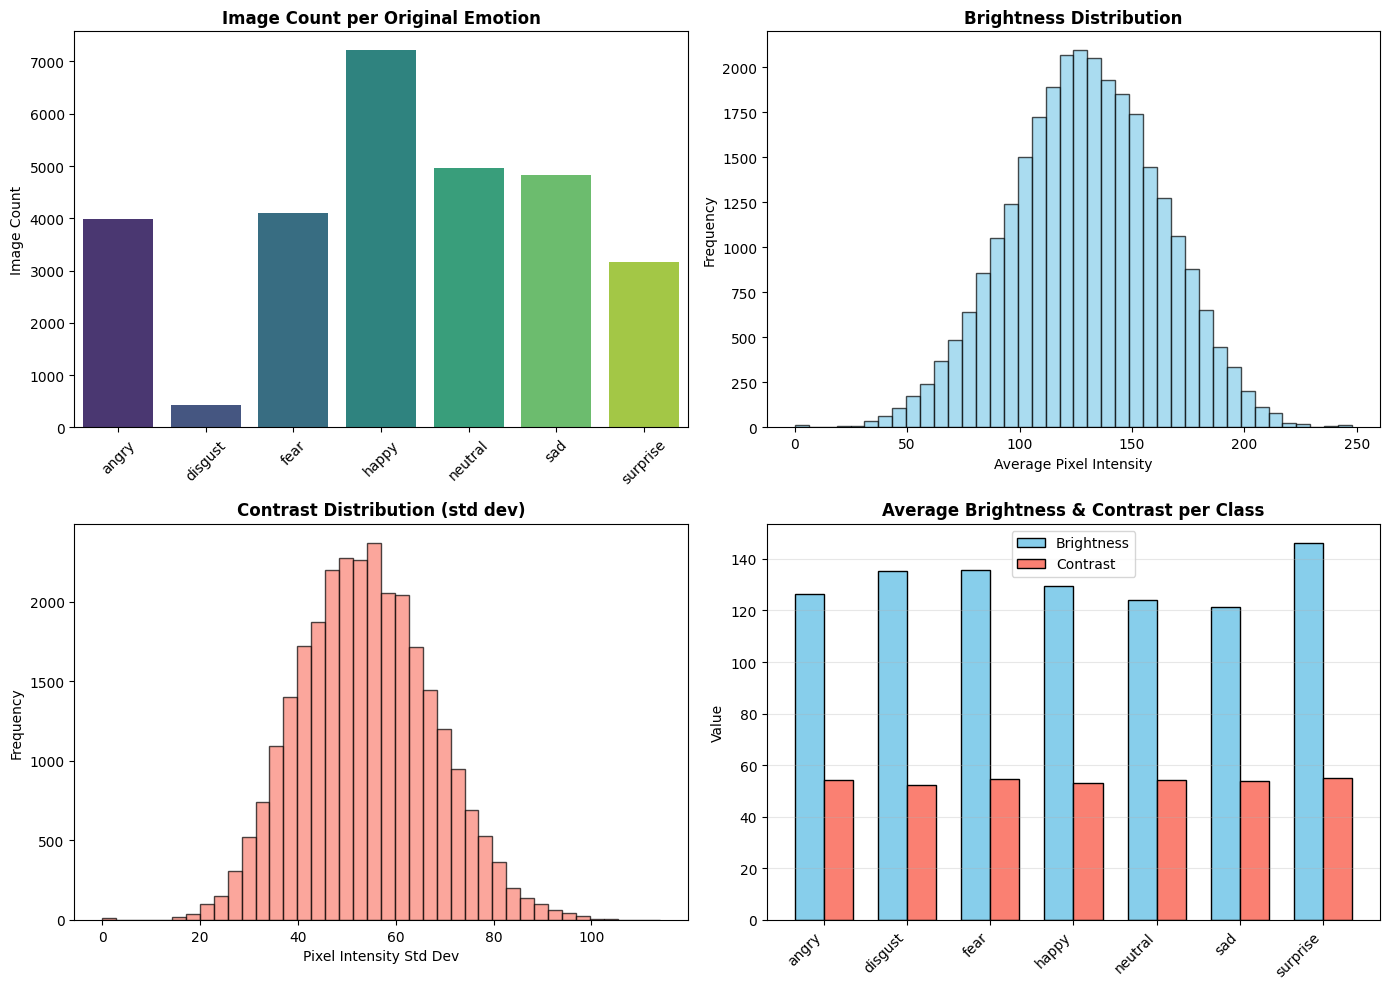

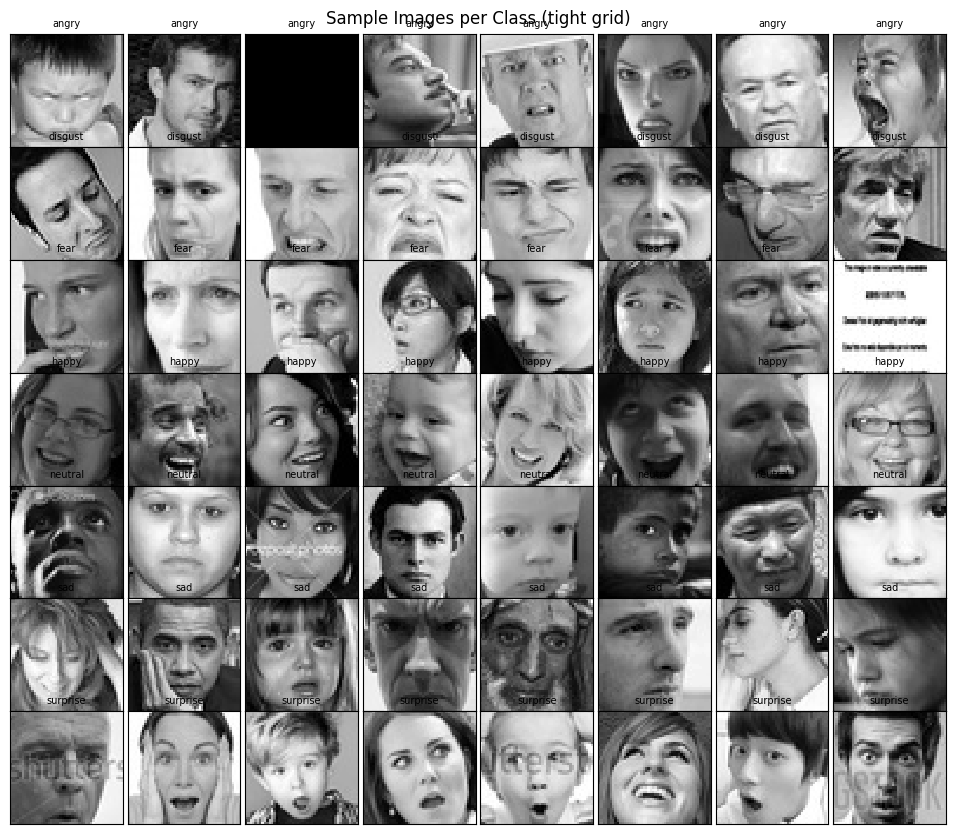

In [3]:
# Combined distributions: 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Class distribution
ax0 = axes[0, 0]
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=ax0, palette='viridis')
ax0.set_title("Image Count per Original Emotion", fontsize=12, fontweight='bold')
ax0.set_ylabel("Image Count")
ax0.tick_params(axis='x', rotation=45)

# Brightness histogram
ax1 = axes[0, 1]
ax1.hist(brightness_vals, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title("Brightness Distribution", fontsize=12, fontweight='bold')
ax1.set_xlabel("Average Pixel Intensity")
ax1.set_ylabel("Frequency")

# Contrast histogram
ax2 = axes[1, 0]
ax2.hist(contrast_vals, bins=40, color='salmon', edgecolor='black', alpha=0.7)
ax2.set_title("Contrast Distribution (std dev)", fontsize=12, fontweight='bold')
ax2.set_xlabel("Pixel Intensity Std Dev")
ax2.set_ylabel("Frequency")

# Brightness + Contrast per class (grouped bar)
ax3 = axes[1, 1]
classes = list(class_brightness.keys())
mean_brightness = [np.mean(class_brightness[cls]) for cls in classes]
mean_contrast = [np.mean(class_contrast[cls]) for cls in classes]

x = np.arange(len(classes))
width = 0.35

bars1 = ax3.bar(x - width/2, mean_brightness, width, label='Brightness', color='skyblue', edgecolor='black')
bars2 = ax3.bar(x + width/2, mean_contrast, width, label='Contrast', color='salmon', edgecolor='black')

ax3.set_title("Average Brightness & Contrast per Class", fontsize=12, fontweight='bold')
ax3.set_ylabel("Value")
ax3.set_xticks(x)
ax3.set_xticklabels(classes, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Sample images (dense, no spacing)
num_samples = len(sample_images)
if num_samples:
    cols = 8
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.2, rows * 1.2), squeeze=False, gridspec_kw={'wspace':0,'hspace':0})
    axs = axes.flatten()
    for i, (label, img) in enumerate(sample_images):
        ax = axs[i]
        if isinstance(img, Image.Image):
            ax.imshow(np.array(img), cmap='gray', interpolation='nearest')
        else:
            ax.imshow(img, cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label, fontsize=7)
    # turn off any unused axes
    for j in range(num_samples, len(axs)):
        axs[j].axis('off')
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.01)
    plt.suptitle("Sample Images per Class (tight grid)")
    plt.show()

# Small images per class
if small_images:
    small_class_counts = {}
    for path in small_images:
        cls = os.path.basename(os.path.dirname(path))
        small_class_counts[cls] = small_class_counts.get(cls, 0) + 1

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(small_class_counts.keys()), y=list(small_class_counts.values()))
    plt.title("Small Images (<32x32) per Class")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Invalid mode images per class
if invalid_modes:
    mode_class_counts = {}
    for path, mode in invalid_modes:
        cls = os.path.basename(os.path.dirname(path))
        key = f"{cls} ({mode})"
        mode_class_counts[key] = mode_class_counts.get(key, 0) + 1

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(mode_class_counts.keys()), y=list(mode_class_counts.values()))
    plt.title("Non-Standard Color Modes per Class")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



## Summary

In [4]:
print("="*60)
print("DATASET SUMMARY REPORT")
print("="*60)

print(f"Total Classes : {len(class_counts)}\n")

print("Class Distribution")
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"   • {cls:12s} : {count:>5,} images")

print(f"\nData Quality Issues")
print(f"   • Corrupted files      : {len(corrupted_files)}")
if corrupted_files:
    print(f"     Example: {os.path.basename(corrupted_files[0][0])}")
print(f"   • Small images (<32px) : {len(small_images)}")
print(f"   • Non-standard modes   : {len(invalid_modes)}")

print(f"\nBrightness Statistics")
print(f"   • Mean     : {np.mean(brightness_vals):.2f}")
print(f"   • Std Dev  : {np.std(brightness_vals):.2f}")
print(f"   • Min      : {np.min(brightness_vals):.2f}")
print(f"   • Max      : {np.max(brightness_vals):.2f}")

print(f"\nContrast Statistics")
print(f"   • Mean     : {np.mean(contrast_vals):.2f}")
print(f"   • Std Dev  : {np.std(contrast_vals):.2f}")
print(f"   • Min      : {np.min(contrast_vals):.2f}")
print(f"   • Max      : {np.max(contrast_vals):.2f}")

print("\n" + "="*60)
print("Per-Class Average Metrics")
print("="*60)
for cls in sorted(class_brightness.keys()):
    avg_bright = np.mean(class_brightness[cls])
    avg_contrast = np.mean(class_contrast[cls])
    print(f"{cls:12s} | Brightness: {avg_bright:6.2f} | Contrast: {avg_contrast:6.2f}")
print("="*60)


DATASET SUMMARY REPORT
Total Classes : 7

Class Distribution
   • happy        : 7,215 images
   • neutral      : 4,965 images
   • sad          : 4,830 images
   • fear         : 4,097 images
   • angry        : 3,995 images
   • surprise     : 3,171 images
   • disgust      :   436 images

Data Quality Issues
   • Corrupted files      : 0
   • Small images (<32px) : 0
   • Non-standard modes   : 0

Brightness Statistics
   • Mean     : 129.47
   • Std Dev  : 33.50
   • Min      : 0.00
   • Max      : 247.95

Contrast Statistics
   • Mean     : 54.05
   • Std Dev  : 13.65
   • Min      : 0.00
   • Max      : 113.93

Per-Class Average Metrics
angry        | Brightness: 126.23 | Contrast:  54.42
disgust      | Brightness: 135.23 | Contrast:  52.22
fear         | Brightness: 135.52 | Contrast:  54.68
happy        | Brightness: 129.43 | Contrast:  53.15
neutral      | Brightness: 123.90 | Contrast:  54.29
sad          | Brightness: 121.28 | Contrast:  53.75
surprise     | Brightness: 146.

## Findings & Conclusions

### Key Observations

**Class Imbalance Issues**
- The `happy` class dominates with 7,215 images
- The `disgust` class has only 436 images (too few for training)
- Significant imbalance could bias model predictions

**Data Quality**
- Some images are poor quality (fully black or watermarked)
- Brightness distribution appears normal (consistent lighting)
- No critical corruption issues found

**Image Properties**
- Most images are properly sized
- Color modes are consistent (grayscale/RGB)
- Contrast varies significantly across classes

### Recommended Actions

**Class Modifications**
- Remove `disgust` class due to insufficient samples
- Use only 5 emotions: `happy`, `sad`, `neutral`, `angry`, `surprised`
- Downsample overrepresented classes to balance dataset

**Quality Filtering**
- Remove fully black/white images
- Filter out watermarked images
- Apply brightness and contrast thresholds
- Remove duplicate images (hash-based)

**Final Dataset Strategy**
- Target: 3,500 images per class (balanced)
- Apply quality filters during preprocessing
- Maintain 70/15/15 train/val/test split

### Selected Emotion Classes

Final 5 emotions for model training:
- `angry` - negative, high arousal
- `happy` - positive, high arousal
- `neutral` - neutral, low arousal
- `sad` - negative, low arousal
- `surprised` - neutral/positive, high arousal
